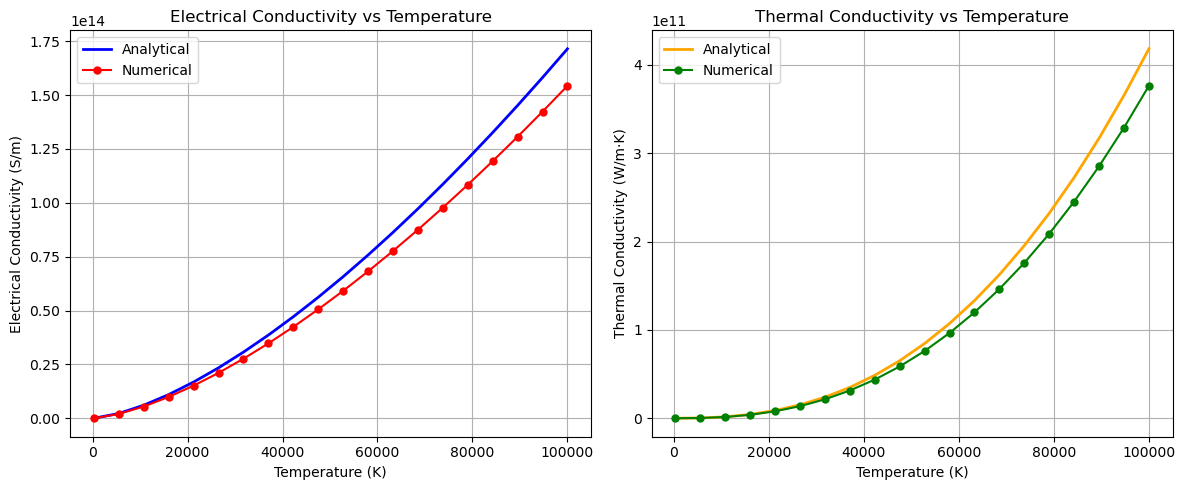

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
n = 1e28      # electron density (m^-3)
e = 1.602e-19 # electron charge (C)
m = 9.11e-31  # electron mass (kg)
L = 2.44e-8   # Lorenz number (W·Ω·K^-2)
nu0 = 1e10    # reference collision frequency (s^-1)
T0 = 300      # reference temperature (K)
E_field = 1.0 # constant electric field (V/m)

# Temperature range
T = np.linspace(300, 1e5, 20)

# --- Analytical Solution ---
nu_e_anal = nu0 * (T / T0)**(-1.5)  # collision frequency
tau_anal = 1 / nu_e_anal            # relaxation time
sigma_anal = (n * e**2 * tau_anal) / m  # electrical conductivity
kappa_anal = L * sigma_anal * T     # thermal conductivity

# --- Numerical Solution ---
sigma_num = []
num_points = 1000  # reduced for efficiency, since t_span is dynamic

for temp in T:
    nu_e = nu0 * (temp / T0)**(-1.5)  # collision frequency at this T
    tau = 1 / nu_e                    # relaxation time
    t_span = [0, 10 * tau]            # time span: 10 relaxation times
    t_eval = np.linspace(t_span[0], t_span[1], num_points)  # time points
    
    # Define ODE: m dv/dt = eE - m nu_e v
    def ode(t, v):
        return (e * E_field - m * nu_e * v) / m
    
    # Solve ODE numerically
    sol = solve_ivp(ode, t_span, [0], t_eval=t_eval, method='RK45')
    v = sol.y[0]  # velocity over time
    
    # Compute average velocity numerically (trapezoidal rule)
    v_avg = np.trapz(v, t_eval) / (t_span[1] - t_span[0])
    
    # Compute sigma = n e <v> / E
    j = n * e * v_avg  # current density
    sigma = j / E_field
    sigma_num.append(sigma)

sigma_num = np.array(sigma_num)
kappa_num = L * sigma_num * T  # thermal conductivity

# --- Plotting ---
plt.figure(figsize=(12, 5))

# Electrical Conductivity Plot
plt.subplot(1, 2, 1)
plt.plot(T, sigma_anal, label='Analytical', color='blue', linewidth=2)
plt.plot(T, sigma_num, 'o-', label='Numerical', color='red', markersize=5)
plt.xlabel('Temperature (K)')
plt.ylabel('Electrical Conductivity (S/m)')
plt.title('Electrical Conductivity vs Temperature')
plt.grid(True)
plt.legend()

# Thermal Conductivity Plot
plt.subplot(1, 2, 2)
plt.plot(T, kappa_anal, label='Analytical', color='orange', linewidth=2)
plt.plot(T, kappa_num, 'o-', label='Numerical', color='green', markersize=5)
plt.xlabel('Temperature (K)')
plt.ylabel('Thermal Conductivity (W/m·K)')
plt.title('Thermal Conductivity vs Temperature')
plt.grid(True)
plt.legend()

# Adjust layout and save
plt.tight_layout()
plt.savefig('conductivities_comparison.png')
plt.show()

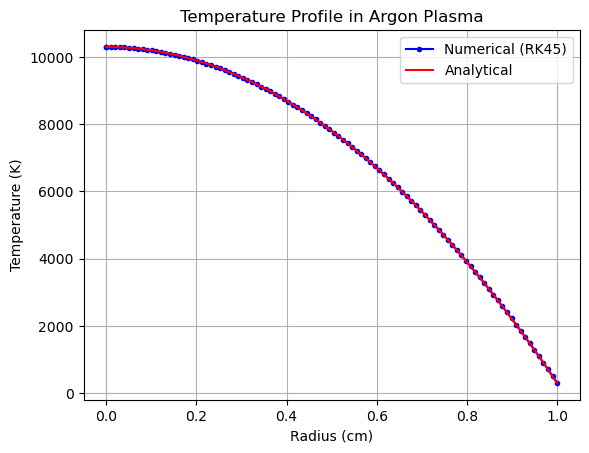

Analytical T(0): 10300.00 K
T(R) numerical: 300.00 K (should be 300.0 K)
Max difference from analytical: 2.04e-07 K


In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
R = 1.0  # cm
T_0 = 300.0  # K
E = 1000.0  # V/cm
sigma = 4000.0  # ohm^-1 cm^-1
kappa = 1e5  # erg/(s·cm·K)
r_span = (1e-6, R)  # Avoid r=0 singularity
N = 100

# Analytical solution
sigma_E2_over_kappa = sigma * E**2 / kappa
T_max_analytical = T_0 + (sigma_E2_over_kappa / 4) * R**2

# ODE system
def dTdr(r, y):
    T, S = y
    dT_dr = S
    dS_dr = -sigma_E2_over_kappa - S / r if r > 0 else 0  # Handle r=0
    return [dT_dr, dS_dr]

# Initial conditions: T(0) = guess, S(0) = 0
T0_guess = T_max_analytical  # Start with analytical max
initial_conditions = [T0_guess, 0.0]

# Solve using RK45
sol = solve_ivp(dTdr, r_span, initial_conditions, method='RK45', 
                t_eval=np.linspace(r_span[0], R, N))

# Extract numerical solution
r_num = sol.t
T_num = sol.y[0]

# Include r=0 explicitly
r_num = np.insert(r_num, 0, 0)
T_num = np.insert(T_num, 0, T0_guess)

# Analytical solution for comparison
T_analytical = T_0 + (sigma_E2_over_kappa / 4) * (R**2 - r_num**2)

# Plot results
plt.plot(r_num, T_num, 'b.-', label='Numerical (RK45)')
plt.plot(r_num, T_analytical, 'r-', label='Analytical')
plt.xlabel('Radius (cm)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Profile in Argon Plasma')
plt.legend()
plt.grid(True)
plt.show()


# Verify boundary condition and max difference
print(f"Analytical T(0): {T_max_analytical:.2f} K")  # Should be ~10300 K
print(f"T(R) numerical: {T_num[-1]:.2f} K (should be {T_0} K)")
print(f"Max difference from analytical: {np.max(np.abs(T_num - T_analytical)):.2e} K")

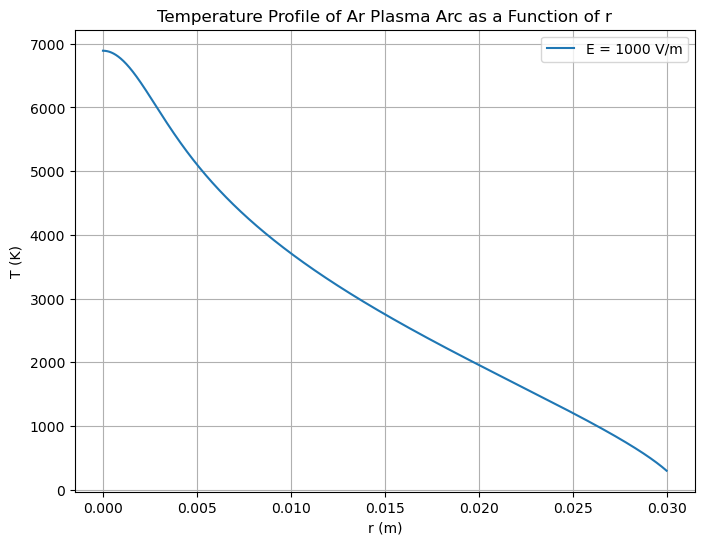

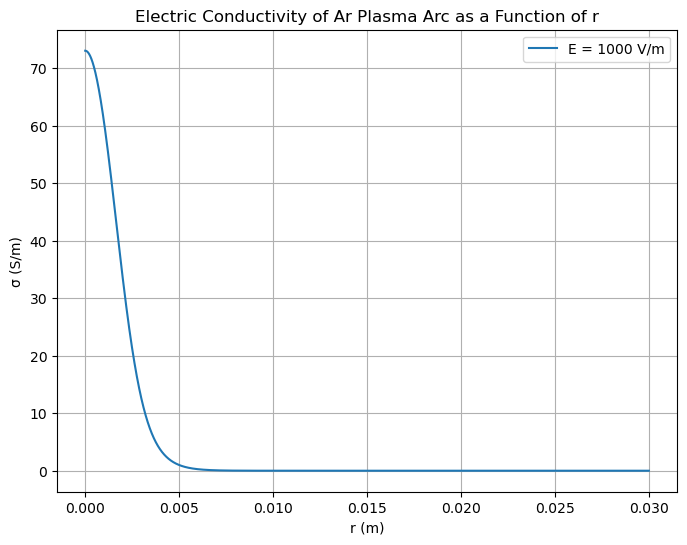

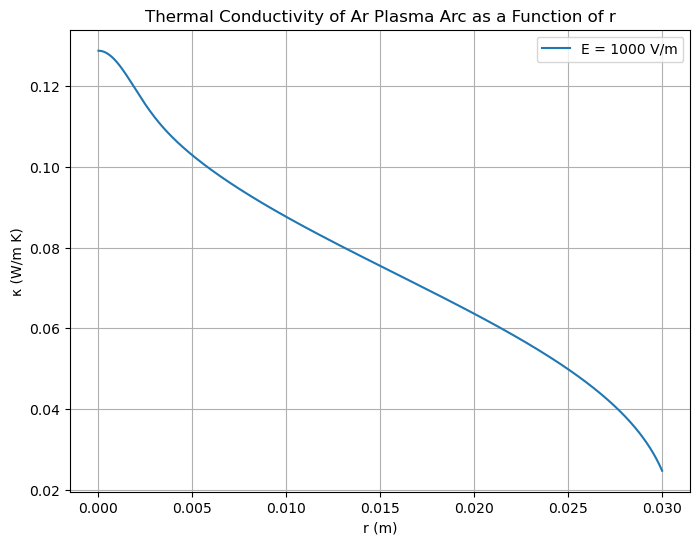

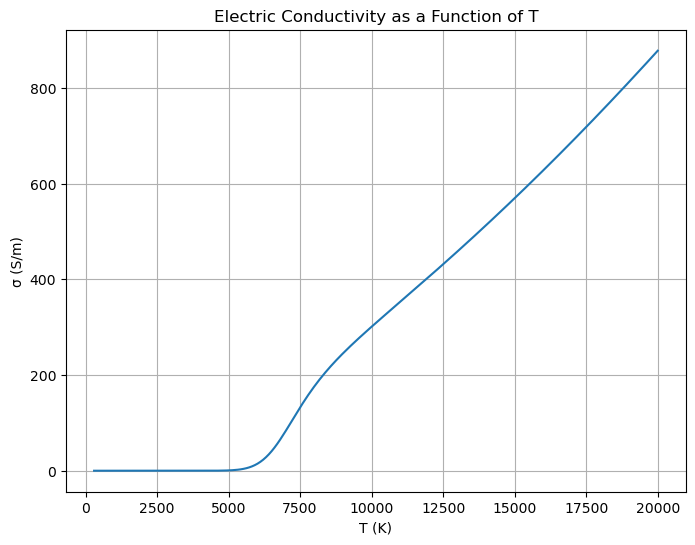

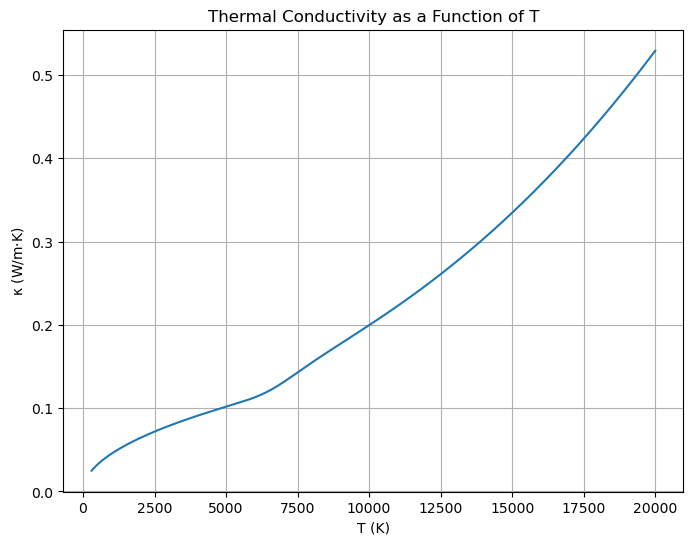

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.2111353899179143


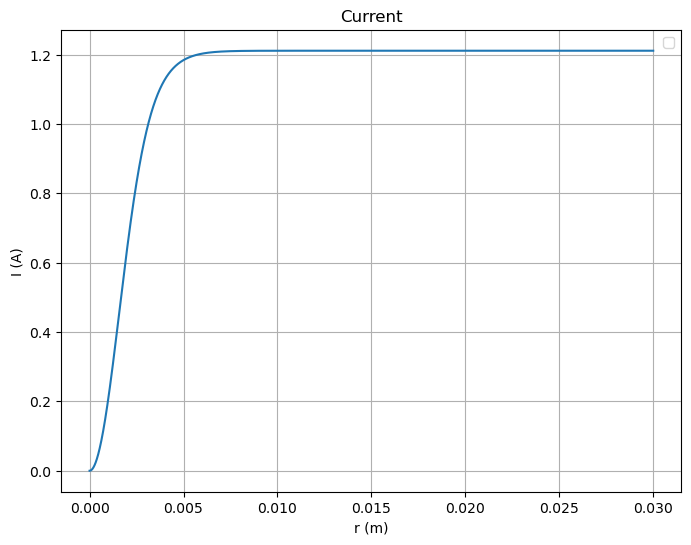

In [3]:
%reset -f
# Libraries
import numpy as np
from sympy import nsolve
from sympy.abc import x, y, z, u, v
from matplotlib import pyplot as plt
from scipy.integrate import odeint

# Constants
gi = 6.
ge = 2.
ga = 1.
m_e = 9.1093837e-31 #kg
m_a = 6.6335209e-26 #kg
h = 6.62607015e-34  # Planck's constant (J s)
h_= h/2/np.pi #4.135*10**(-15)  #
k = 1.380649e-23
e = 1.60218e-19
J = 15.6 * e # 15.6 #eV
P_atm = 101325
p = [1.]
R = 8.314
Na = 6.02214076e23
Ev = 1000 #V/m
Qea = 1e-19 #m^2
Qei = 1e-16 #m^2
Qaa = 2e-19 #m^2
cp=5/2*k
RR = 0.03 #m
Temp_d = np.linspace(4800,15200,105)
Temp = np.linspace(300,20000,201)
n_i = 100001
in_ = 1e-50
fi_ = 0.03
r_ = np.linspace(in_,fi_,n_i)

def f(T,P=P_atm):
    return (gi*ge/ga) * (m_e*k*T/(2*np.pi*h_**2))**(3/2) * np.exp(-J/(k*T))

def ηe(T,P=P_atm):
    return -f(T,P) + np.sqrt(f(T,P)**2+f(T,P)*(P/(k*T)))

def ηa(T,P=P_atm):
    return P/(k*T)-2*ηe(T,P)

def df(T,P=P_atm):
    return f(T,P)*(J/(k*T**2)+3/(2*T))

def dηe(T,P=P_atm):
    return -df(T,P) + (P*T*df(T,P) - f(T,P)*( P - (2*k*T**2)*df(T,P) ) ) / ( (2*k*T**2) * np.sqrt( f(T,P)*( f(T,P) + P/(k*T) ) ))

def dηa(T,P=P_atm):
    return -2*dηe(T,P) - P/(k*T**2)

def d_dT(l,h):
    return [(-l[i+2]+8*l[i+1]-8*l[i-1]+l[i-2])/(12*h) for i in range(2,103,1)]

def dκ(T,P=P_atm):
    gT=ηa(T,P)
    fT=ηe(T,P)
    gp=dηa(T,P)
    fp=dηe(T,P)
    Q=Qea
    O=Qei
    P=Qaa
    q=e
    c=cp
    return (c*np.sqrt((k*T)/m_e)*(O*q**2*(np.sqrt(m_e/m_a)*O*q**2 + 5*k**2*P*T**2)*fT**2 + k**4*Q*T**4*gT*(np.sqrt(m_e/m_a)*Q*gT + 2*P*T*fp) + k**2*Q*T**2*fT*((2*np.sqrt(m_e/m_a)*O*q**2 + k**2*P*T**2)*gT - 2*k**2*P*T**3*gp)))/(2*np.sqrt(3)*P*T*(O*q**2*fT + k**2*Q*T**2*gT)**2)

def σ(T,P=P_atm):
    return ηe(T,P)*e**2 / (np.sqrt(3*m_e*k*T) * ( ηa(T,P)*Qea + ηe(T,P)*Qei*(e/(k*T))**2 ))

def κ(T,P=P_atm):
    return np.sqrt(3*k*T/m_e) * ( (cp/(3*Qaa)*np.sqrt(m_e/m_a)) + ηe(T,P)*cp/( 3*(ηa(T,P)*Qea + ηe(T,P)*Qei*(e/(k*T))**2) ))

def φ(r,T,P,dT):
    if r==0.:
        return - σ(T,P)/κ(T,P)*Ev**2
    else:
        return -(1/κ(T,P))*dκ(T,P)*(dT)**2 - (1/r)*(dT) - σ(T,P)/κ(T,P)*Ev**2

def RKN4(r,T,P,dT,h):
    k1 = φ(r,T,P,dT)
    dT1 = dT + k1*(h/2)
    T1 = T + (h/2)*((dT+dT1)/2)

    k2 = φ( r + h/2 , T1 , P , dT1  )
    dT2 = dT + k2*(h/2)
    T2 = T + (h/2)*((dT+dT2)/2)

    k3 = φ( r + h/2 , T2 , P , dT2  )
    dT3 = dT + k3*(h/2)
    T3 = T + (h/2)*((dT+dT3)/2)

    k4 = φ( r + h , T3 , P , dT3  )

    dT_ = dT + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    T_ = T + (h/6)*(dT + 2*dT1 + 2*dT2 + T3)

    return T_, dT_

def NInt(f_l,x_l):
    Δx=x_l[1]-x_l[0]
    I=Δx*(sum(f_l)-(f_l[0]+f_l[-1])/2)
    return I

def T_derivatives(x,r):
    return [x[1] , -(1/κ(x[0]))*dκ(x[0])*(x[1])**2 - (1/r)*(x[1]) - σ(x[0])/κ(x[0])*Ev**2 ]

h = (fi_-in_)/(n_i-1)
Tf=4800
T0=5403.5
T0=7490
T0=6890
while Tf > 298 or Tf < 297:
    T_l = [T0]
    dT_l = [0]
    T_l , dT_l = odeint(T_derivatives, [T0,0], r_).T
    Tf = T_l[n_i-1]
    dT1 = dT_l[1]
    T0 = T0 + 0.1

plt.figure(figsize=(8, 6))
plt.plot(r_,T_l,linestyle='-',label=f'E = {Ev} V/m')
plt.ylabel('T (K)')
plt.xlabel('r (m)')
plt.legend()
plt.title('Temperature Profile of Ar Plasma Arc as a Function of r')
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(r_,[σ(T,P_atm) for T in T_l],linestyle='-',label=f'E = {Ev} V/m')
plt.ylabel('σ (S/m)')
plt.xlabel('r (m)')
plt.legend()
plt.title('Electric Conductivity of Ar Plasma Arc as a Function of r')
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(r_,[κ(T,P_atm) for T in T_l],linestyle='-',label=f'E = {Ev} V/m')
plt.ylabel('κ (W/m K)')
plt.xlabel('r (m)')
plt.legend()
plt.title('Thermal Conductivity of Ar Plasma Arc as a Function of r')
plt.grid()
plt.show()
plt.figure(figsize=(8, 6))
plt.plot(Temp,[σ(T,P_atm) for T in Temp],linestyle='-')

plt.ylabel('σ (S/m)')
plt.xlabel('T (K)')
plt.title('Electric Conductivity as a Function of T')
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(Temp,[κ(T,P_atm) for T in Temp],linestyle='-')

plt.ylabel('κ (W/m$\cdot$K)')
plt.xlabel('T (K)')
plt.title('Thermal Conductivity as a Function of T')
plt.grid()
plt.show()

F=[]
for i in range(0,len(r_),1):
  F.append( 2*np.pi*r_[i] * σ(T_l[i],P_atm)*Ev )

print(NInt(F ,r_))

I=[ F[0]/2 , h*(F[0]/2+F[1]/2) ]
for i in range(2,len(r_)-1,1):
  I.append( I[i-1] + h*(F[i-1]+F[i])/2)

plt.figure(figsize=(8, 6))
plt.plot(r_[:len(r_)-1],I,linestyle='-')

plt.ylabel('I (A)')
plt.xlabel('r (m)')
plt.legend()
plt.title('Current')
plt.grid()
plt.show()


Total current (A): 1.2111353899179143


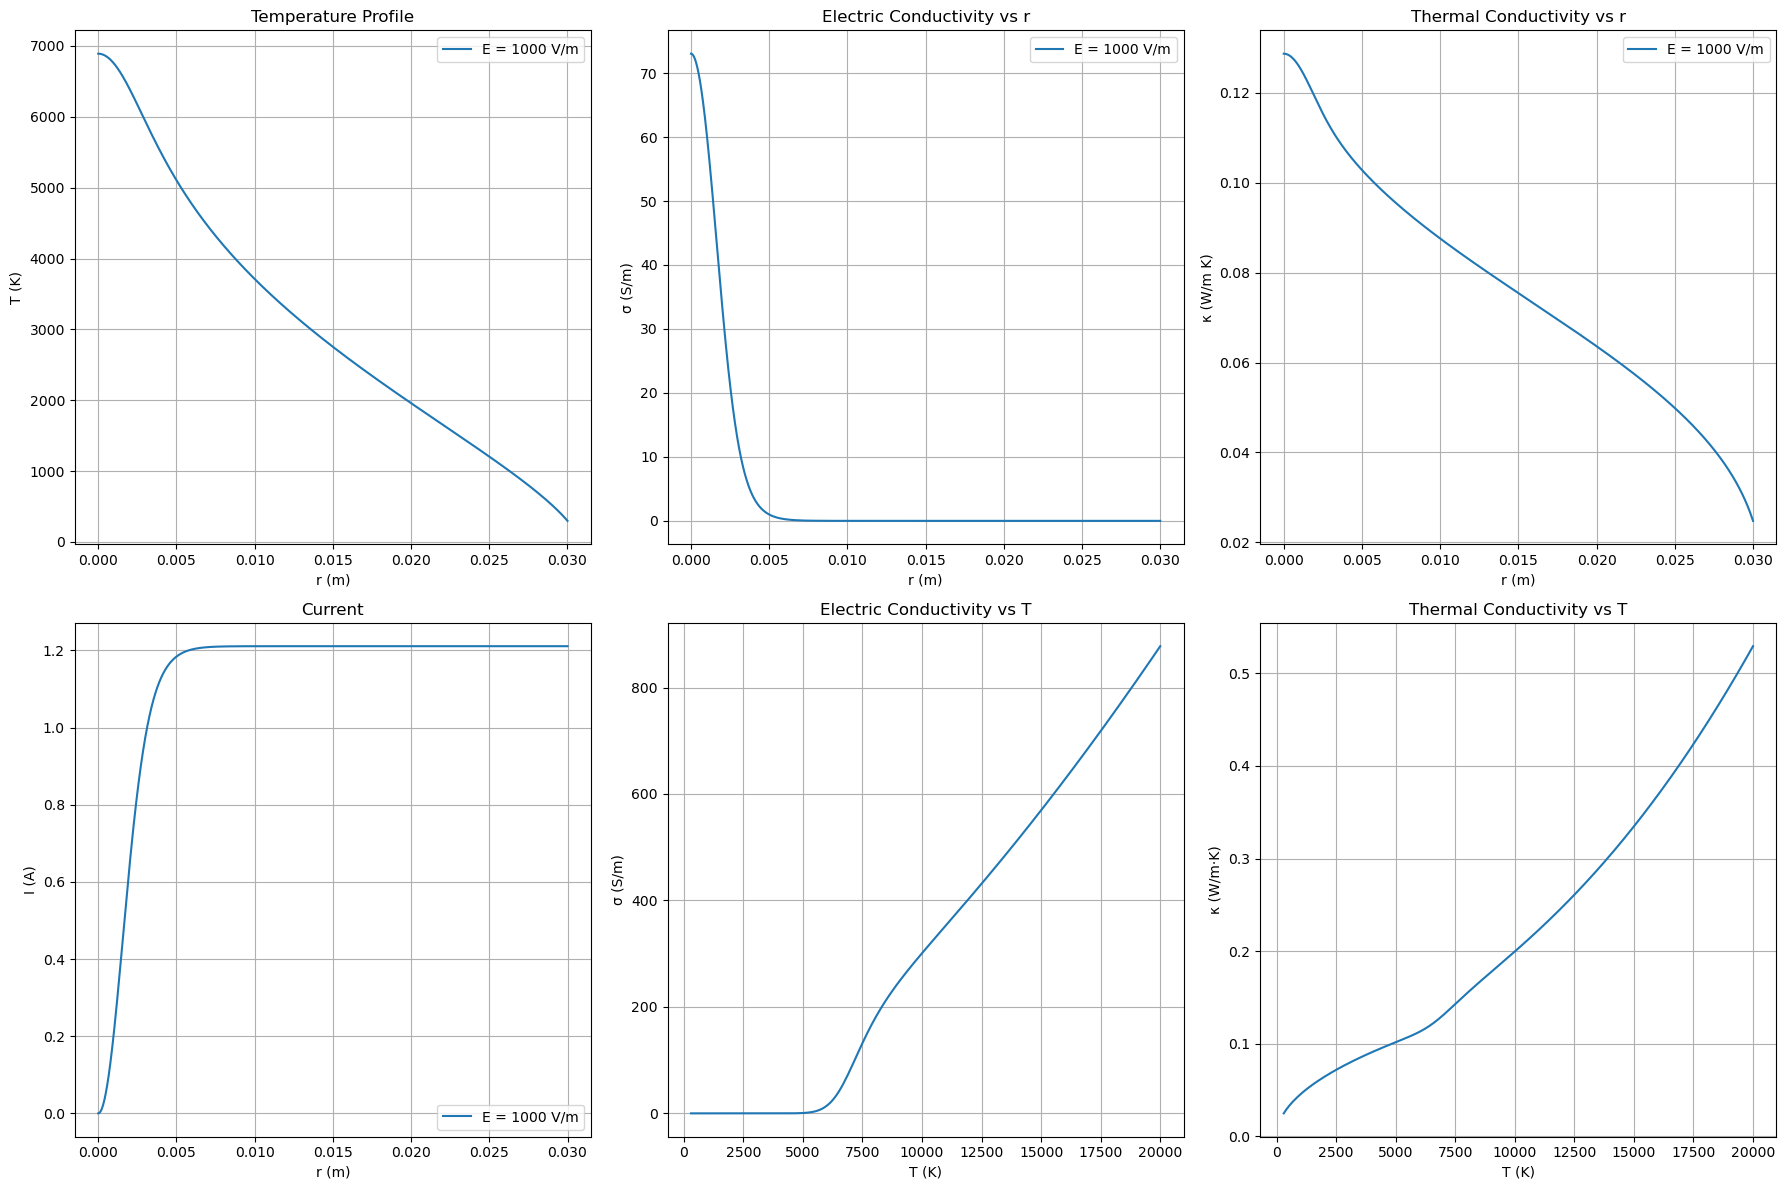

In [4]:
# Libraries
import numpy as np
from sympy import nsolve
from sympy.abc import x, y, z, u, v
from matplotlib import pyplot as plt
from scipy.integrate import odeint

# Constants
gi = 6.
ge = 2.
ga = 1.
m_e = 9.1093837e-31  # kg
m_a = 6.6335209e-26  # kg
h = 6.62607015e-34   # Planck's constant (J s)
h_ = h / (2 * np.pi) # Reduced Planck's constant
k = 1.380649e-23     # Boltzmann constant (J/K)
e = 1.60218e-19      # Electron charge (C)
J = 15.6 * e         # Ionization energy (J)
P_atm = 101325       # Atmospheric pressure (Pa)
p = [1.]             # Unused
R = 8.314            # Gas constant (J/mol·K)
Na = 6.02214076e23   # Avogadro's number
Ev = 1000            # Electric field (V/m)
Qea = 1e-19          # Cross-section (m^2)
Qei = 1e-16          # Cross-section (m^2)
Qaa = 2e-19          # Cross-section (m^2)
cp = 5/2 * k         # Specific heat
RR = 0.03            # Radius (m)
Temp_d = np.linspace(4800, 15200, 105)  # Unused
Temp = np.linspace(300, 20000, 201)     # Temperature range for σ(T), κ(T)
n_i = 100001         # Number of radial points
in_ = 1e-50          # Inner radius (m)
fi_ = 0.03           # Outer radius (m)
r_ = np.linspace(in_, fi_, n_i)  # Radial array

# Function definitions
def f(T, P=P_atm):
    return (gi * ge / ga) * (m_e * k * T / (2 * np.pi * h_**2))**(3/2) * np.exp(-J / (k * T))

def ηe(T, P=P_atm):
    return -f(T, P) + np.sqrt(f(T, P)**2 + f(T, P) * (P / (k * T)))

def ηa(T, P=P_atm):
    return P / (k * T) - 2 * ηe(T, P)

def df(T, P=P_atm):
    return f(T, P) * (J / (k * T**2) + 3 / (2 * T))

def dηe(T, P=P_atm):
    return -df(T, P) + (P * T * df(T, P) - f(T, P) * (P - (2 * k * T**2) * df(T, P))) / \
           ((2 * k * T**2) * np.sqrt(f(T, P) * (f(T, P) + P / (k * T))))

def dηa(T, P=P_atm):
    return -2 * dηe(T, P) - P / (k * T**2)

def d_dT(l, h):  # Unused
    return [(-l[i+2] + 8*l[i+1] - 8*l[i-1] + l[i-2]) / (12 * h) for i in range(2, 103, 1)]

def dκ(T, P=P_atm):
    gT = ηa(T, P)
    fT = ηe(T, P)
    gp = dηa(T, P)
    fp = dηe(T, P)
    Q = Qea
    O = Qei
    P = Qaa
    q = e
    c = cp
    return (c * np.sqrt((k * T) / m_e) * (O * q**2 * (np.sqrt(m_e / m_a) * O * q**2 + 5 * k**2 * P * T**2) * fT**2 +
            k**4 * Q * T**4 * gT * (np.sqrt(m_e / m_a) * Q * gT + 2 * P * T * fp) +
            k**2 * Q * T**2 * fT * ((2 * np.sqrt(m_e / m_a) * O * q**2 + k**2 * P * T**2) * gT - 2 * k**2 * P * T**3 * gp))) / \
           (2 * np.sqrt(3) * P * T * (O * q**2 * fT + k**2 * Q * T**2 * gT)**2)

def σ(T, P=P_atm):
    return ηe(T, P) * e**2 / (np.sqrt(3 * m_e * k * T) * (ηa(T, P) * Qea + ηe(T, P) * Qei * (e / (k * T))**2))

def κ(T, P=P_atm):
    return np.sqrt(3 * k * T / m_e) * ((cp / (3 * Qaa) * np.sqrt(m_e / m_a)) +
           ηe(T, P) * cp / (3 * (ηa(T, P) * Qea + ηe(T, P) * Qei * (e / (k * T))**2)))

def φ(r, T, P, dT):
    if r == 0.:
        return -σ(T, P) / κ(T, P) * Ev**2
    else:
        return -(1 / κ(T, P)) * dκ(T, P) * (dT)**2 - (1 / r) * (dT) - σ(T, P) / κ(T, P) * Ev**2

def RKN4(r, T, P, dT, h):  # Unused
    k1 = φ(r, T, P, dT)
    dT1 = dT + k1 * (h / 2)
    T1 = T + (h / 2) * ((dT + dT1) / 2)
    k2 = φ(r + h/2, T1, P, dT1)
    dT2 = dT + k2 * (h / 2)
    T2 = T + (h / 2) * ((dT + dT2) / 2)
    k3 = φ(r + h/2, T2, P, dT2)
    dT3 = dT + k3 * (h / 2)
    T3 = T + (h / 2) * ((dT + dT3) / 2)
    k4 = φ(r + h, T3, P, dT3)
    dT_ = dT + (h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    T_ = T + (h / 6) * (dT + 2 * dT1 + 2 * dT2 + T3)
    return T_, dT_

def NInt(f_l, x_l):
    Δx = x_l[1] - x_l[0]
    I = Δx * (sum(f_l) - (f_l[0] + f_l[-1]) / 2)
    return I

def T_derivatives(x, r):
    return [x[1], -(1 / κ(x[0])) * dκ(x[0]) * (x[1])**2 - (1 / r) * (x[1]) - σ(x[0]) / κ(x[0]) * Ev**2]

# Simulation
h = (fi_ - in_) / (n_i - 1)
Tf = 4800  # Initial guess
T0 = 6890  # Starting T0 (last assigned value)
while Tf > 298 or Tf < 297:
    T_l, dT_l = odeint(T_derivatives, [T0, 0], r_).T
    Tf = T_l[n_i - 1]
    T0 = T0 + 0.1

# Current calculation
F = [2 * np.pi * r_[i] * σ(T_l[i], P_atm) * Ev for i in range(len(r_))]
print("Total current (A):", NInt(F, r_))
I = [F[0] / 2, h * (F[0] / 2 + F[1] / 2)]
for i in range(2, len(r_) - 1):
    I.append(I[i - 1] + h * (F[i - 1] + F[i]) / 2)

# Plotting all in one figure
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: T(r)
axs[0, 0].plot(r_, T_l, linestyle='-', label=f'E = {Ev} V/m')
axs[0, 0].set_ylabel('T (K)')
axs[0, 0].set_xlabel('r (m)')
axs[0, 0].legend()
axs[0, 0].set_title('Temperature Profile')
axs[0, 0].grid()

# Plot 2: σ(r)
axs[0, 1].plot(r_, [σ(T, P_atm) for T in T_l], linestyle='-', label=f'E = {Ev} V/m')
axs[0, 1].set_ylabel('σ (S/m)')
axs[0, 1].set_xlabel('r (m)')
axs[0, 1].legend()
axs[0, 1].set_title('Electric Conductivity vs r')
axs[0, 1].grid()

# Plot 3: κ(r)
axs[0, 2].plot(r_, [κ(T, P_atm) for T in T_l], linestyle='-', label=f'E = {Ev} V/m')
axs[0, 2].set_ylabel('κ (W/m K)')
axs[0, 2].set_xlabel('r (m)')
axs[0, 2].legend()
axs[0, 2].set_title('Thermal Conductivity vs r')
axs[0, 2].grid()

# Plot 4: I(r)
axs[1, 0].plot(r_[:len(I)], I, linestyle='-', label=f'E = {Ev} V/m')
axs[1, 0].set_ylabel('I (A)')
axs[1, 0].set_xlabel('r (m)')
axs[1, 0].legend()
axs[1, 0].set_title('Current')
axs[1, 0].grid()

# Plot 5: σ(T)
axs[1, 1].plot(Temp, [σ(T, P_atm) for T in Temp], linestyle='-')
axs[1, 1].set_ylabel('σ (S/m)')
axs[1, 1].set_xlabel('T (K)')
axs[1, 1].set_title('Electric Conductivity vs T')
axs[1, 1].grid()

# Plot 6: κ(T)
axs[1, 2].plot(Temp, [κ(T, P_atm) for T in Temp], linestyle='-')
axs[1, 2].set_ylabel('κ (W/m·K)')
axs[1, 2].set_xlabel('T (K)')
axs[1, 2].set_title('Thermal Conductivity vs T')
axs[1, 2].grid()

plt.tight_layout()
plt.show()

Total current (A): 1.2111353899179143


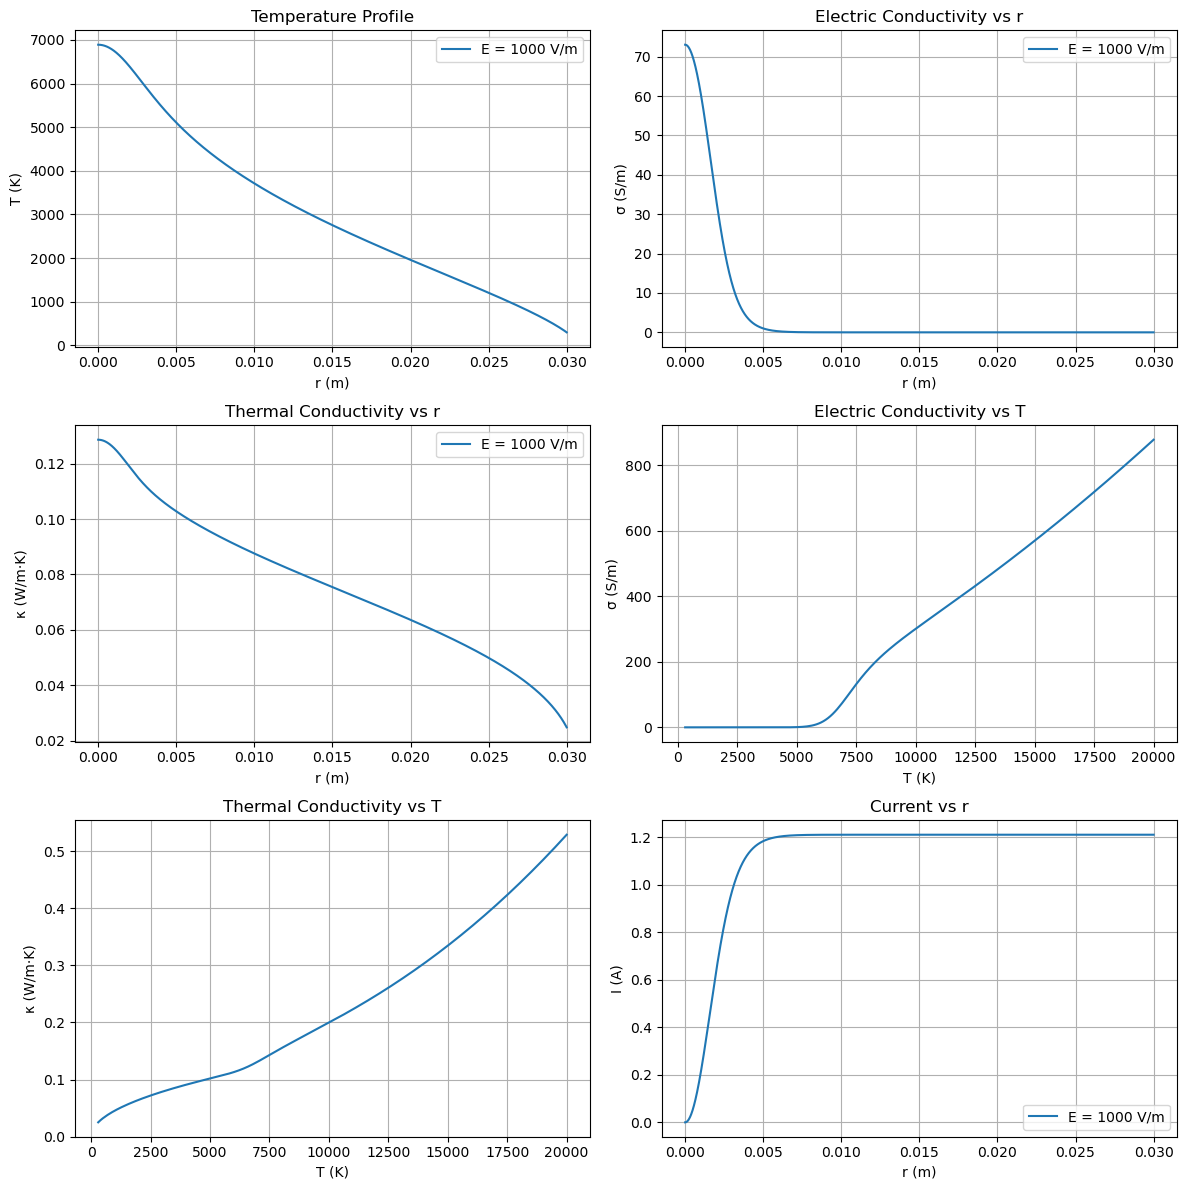

In [5]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Constants
gi = 6.
ge = 2.
ga = 1.
m_e = 9.1093837e-31  # kg
m_a = 6.6335209e-26  # kg
h = 6.62607015e-34   # Planck's constant (J s)
h_ = h / (2 * np.pi) # Reduced Planck's constant
k = 1.380649e-23     # Boltzmann constant (J/K)
e = 1.60218e-19      # Electron charge (C)
J = 15.6 * e         # Ionization energy (J)
P_atm = 101325       # Atmospheric pressure (Pa)
Ev = 1000            # Electric field (V/m)
Qea = 1e-19          # m^2
Qei = 1e-16          # m^2
Qaa = 2e-19          # m^2
cp = 5/2 * k         # Specific heat per particle
RR = 0.03            # Radius (m)
Temp = np.linspace(300, 20000, 201)  # Temperature range for plotting
n_i = 100001         # Number of radial points
in_ = 1e-50          # Inner radius
fi_ = 0.03           # Outer radius
r_ = np.linspace(in_, fi_, n_i)

# Plasma property functions
def f(T, P=P_atm):
    return (gi * ge / ga) * (m_e * k * T / (2 * np.pi * h_**2))**(3/2) * np.exp(-J / (k * T))

def ηe(T, P=P_atm):
    f_val = f(T, P)
    return -f_val + np.sqrt(f_val**2 + f_val * (P / (k * T)))

def ηa(T, P=P_atm):
    return P / (k * T) - 2 * ηe(T, P)

def df(T, P=P_atm):
    f_val = f(T, P)
    return f_val * (J / (k * T**2) + 3 / (2 * T))

def dηe(T, P=P_atm):
    f_val = f(T, P)
    df_val = df(T, P)
    return -df_val + (P * T * df_val - f_val * (P - (2 * k * T**2) * df_val)) / \
           ((2 * k * T**2) * np.sqrt(f_val * (f_val + P / (k * T))))

def dηa(T, P=P_atm):
    return -2 * dηe(T, P) - P / (k * T**2)

def dκ(T, P=P_atm):
    gT = ηa(T, P)
    fT = ηe(T, P)
    gp = dηa(T, P)
    fp = dηe(T, P)
    Q = Qea
    O = Qei
    P = Qaa  # Note: P here is Qaa, not pressure
    q = e
    c = cp
    num = c * np.sqrt((k * T) / m_e) * (
        O * q**2 * (np.sqrt(m_e / m_a) * O * q**2 + 5 * k**2 * P * T**2) * fT**2 +
        k**4 * Q * T**4 * gT * (np.sqrt(m_e / m_a) * Q * gT + 2 * P * T * fp) +
        k**2 * Q * T**2 * fT * ((2 * np.sqrt(m_e / m_a) * O * q**2 + k**2 * P * T**2) * gT - 2 * k**2 * P * T**3 * gp)
    )
    den = 2 * np.sqrt(3) * P * T * (O * q**2 * fT + k**2 * Q * T**2 * gT)**2
    return num / den

def σ(T, P=P_atm):
    return ηe(T, P) * e**2 / (np.sqrt(3 * m_e * k * T) * (ηa(T, P) * Qea + ηe(T, P) * Qei * (e / (k * T))**2))

def κ(T, P=P_atm):
    return np.sqrt(3 * k * T / m_e) * (
        (cp / (3 * Qaa) * np.sqrt(m_e / m_a)) +
        ηe(T, P) * cp / (3 * (ηa(T, P) * Qea + ηe(T, P) * Qei * (e / (k * T))**2))
    )

def T_derivatives(x, r):
    T, dT = x
    if T <= 0:
        raise ValueError(f"Temperature became non-positive: T={T} at r={r}")
    kappa = κ(T)
    return [dT, -(1 / kappa) * dκ(T) * dT**2 - (1 / r) * dT - σ(T) / kappa * Ev**2]

def NInt(f_l, x_l):
    Δx = x_l[1] - x_l[0]
    return Δx * (sum(f_l) - (f_l[0] + f_l[-1]) / 2)

# Solve for temperature profile
T0 = 6890  # Initial temperature guess (K)
Tf = 4800  # Initial Tf to enter loop
while Tf > 298 or Tf < 297:
    sol = odeint(T_derivatives, [T0, 0], r_)
    T_l, dT_l = sol.T
    Tf = T_l[-1]
    T0 += 0.1

# Calculate current
F = [2 * np.pi * r_[i] * σ(T_l[i], P_atm) * Ev for i in range(len(r_))]
I = [F[0] / 2]
for i in range(1, len(r_) - 1):
    I.append(I[-1] + (r_[1] - r_[0]) * (F[i-1] + F[i]) / 2)

# Create combined plots
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Temperature vs r
axs[0, 0].plot(r_, T_l, label=f'E = {Ev} V/m')
axs[0, 0].set_xlabel('r (m)')
axs[0, 0].set_ylabel('T (K)')
axs[0, 0].set_title('Temperature Profile')
axs[0, 0].legend()
axs[0, 0].grid()

# Electric conductivity vs r
axs[0, 1].plot(r_, [σ(T, P_atm) for T in T_l], label=f'E = {Ev} V/m')
axs[0, 1].set_xlabel('r (m)')
axs[0, 1].set_ylabel('σ (S/m)')
axs[0, 1].set_title('Electric Conductivity vs r')
axs[0, 1].legend()
axs[0, 1].grid()

# Thermal conductivity vs r
axs[1, 0].plot(r_, [κ(T, P_atm) for T in T_l], label=f'E = {Ev} V/m')
axs[1, 0].set_xlabel('r (m)')
axs[1, 0].set_ylabel('κ (W/m·K)')
axs[1, 0].set_title('Thermal Conductivity vs r')
axs[1, 0].legend()
axs[1, 0].grid()

# Electric conductivity vs T
axs[1, 1].plot(Temp, [σ(T, P_atm) for T in Temp])
axs[1, 1].set_xlabel('T (K)')
axs[1, 1].set_ylabel('σ (S/m)')
axs[1, 1].set_title('Electric Conductivity vs T')
axs[1, 1].grid()

# Thermal conductivity vs T
axs[2, 0].plot(Temp, [κ(T, P_atm) for T in Temp])
axs[2, 0].set_xlabel('T (K)')
axs[2, 0].set_ylabel('κ (W/m·K)')
axs[2, 0].set_title('Thermal Conductivity vs T')
axs[2, 0].grid()

# Current vs r
axs[2, 1].plot(r_[:len(I)], I, label=f'E = {Ev} V/m')
axs[2, 1].set_xlabel('r (m)')
axs[2, 1].set_ylabel('I (A)')
axs[2, 1].set_title('Current vs r')
axs[2, 1].legend()
axs[2, 1].grid()

plt.tight_layout()
plt.savefig('plasma_plots.png')
print("Total current (A):", NInt(F, r_))

Total current (A): 1.2111353899179143


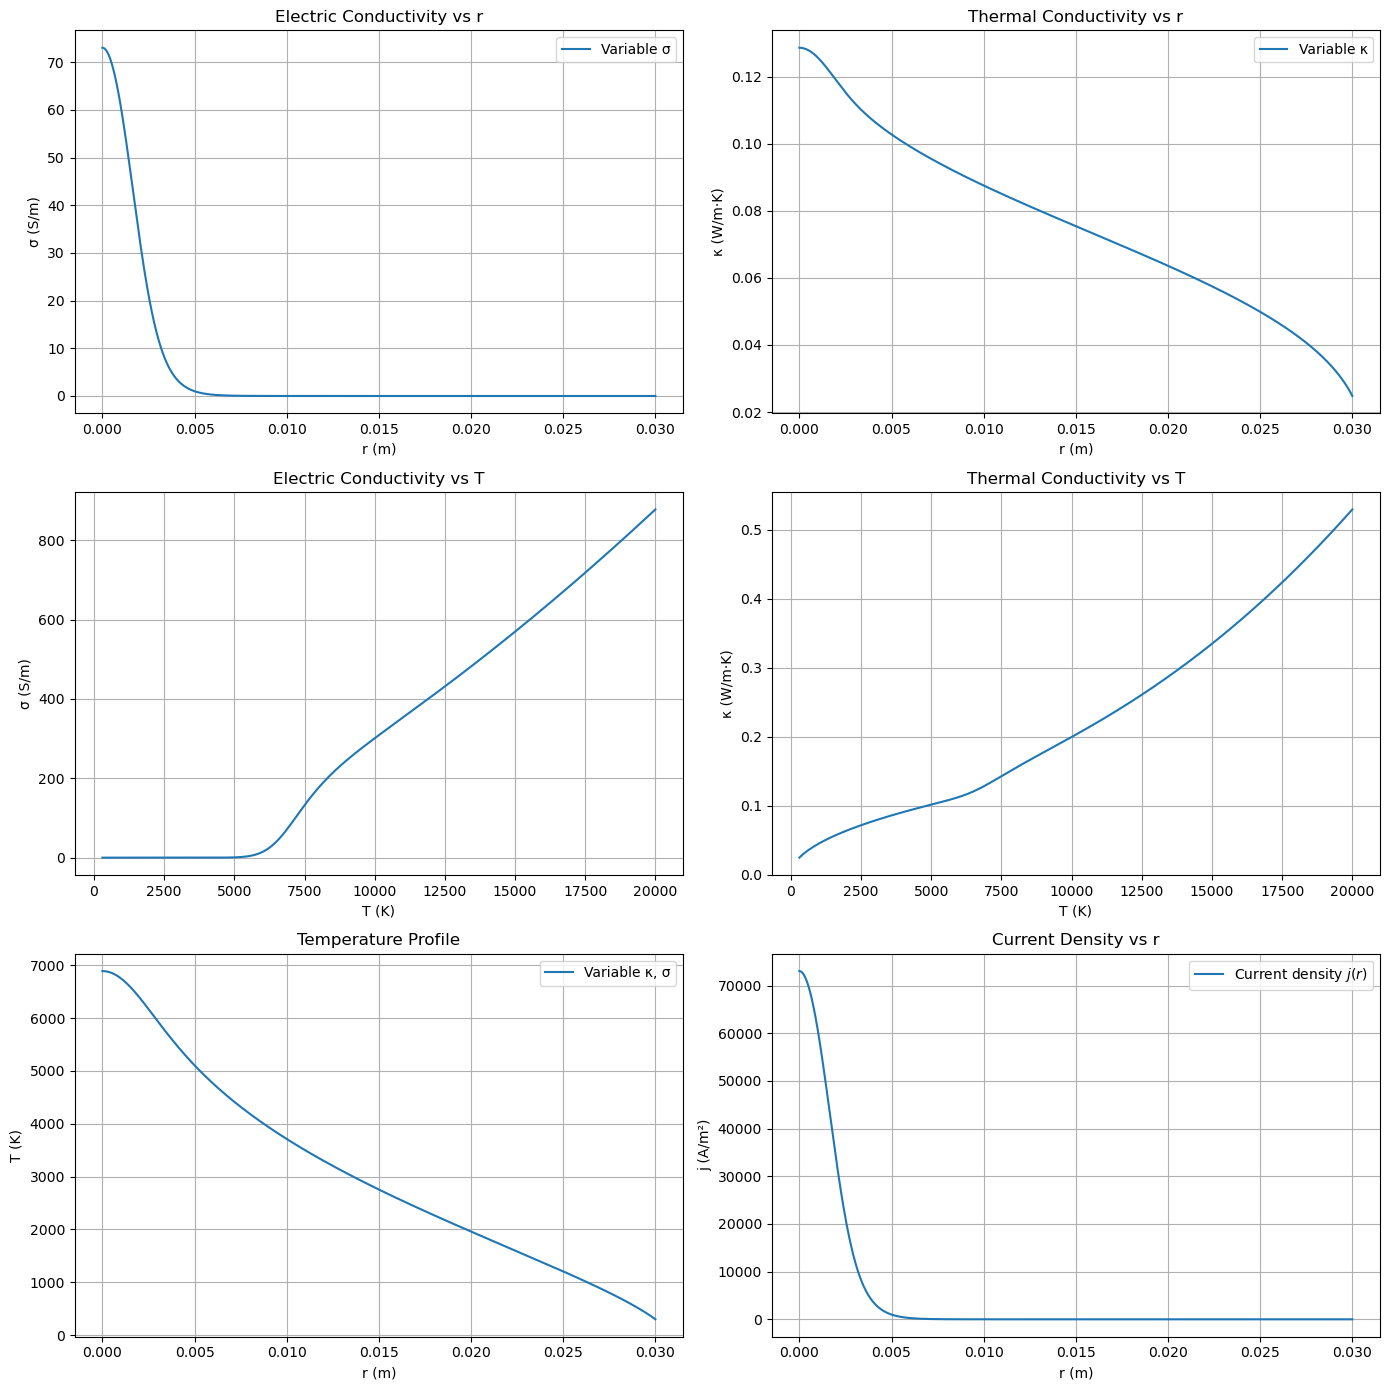

In [ ]:
# ...existing code...
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Constants
gi = 6.
ge = 2.
ga = 1.
m_e = 9.1093837e-31  # kg
m_a = 6.6335209e-26  # kg
h = 6.62607015e-34   # Planck's constant (J s)
h_ = h / (2 * np.pi) # Reduced Planck's constant
k = 1.380649e-23     # Boltzmann constant (J/K)
e = 1.60218e-19      # Electron charge (C)
J = 15.6 * e         # Ionization energy (J)
P_atm = 101325       # Atmospheric pressure (Pa)
Ev = 1000            # Electric field (V/m)
Qea = 1e-19          # m^2
Qei = 1e-16          # m^2
Qaa = 2e-19          # m^2
cp = 5/2 * k         # Specific heat per particle
RR = 0.03            # Radius (m)
Temp = np.linspace(300, 20000, 201)  # Temperature range for plotting
n_i = 100001         # Number of radial points
in_ = 1e-50          # Inner radius
fi_ = 0.03           # Outer radius
r_ = np.linspace(in_, fi_, n_i)

# Plasma property functions
def f(T, P=P_atm):
    return (gi * ge / ga) * (m_e * k * T / (2 * np.pi * h_**2))**(3/2) * np.exp(-J / (k * T))

def ηe(T, P=P_atm):
    f_val = f(T, P)
    return -f_val + np.sqrt(f_val**2 + f_val * (P / (k * T)))

def ηa(T, P=P_atm):
    return P / (k * T) - 2 * ηe(T, P)

def df(T, P=P_atm):
    f_val = f(T, P)
    return f_val * (J / (k * T**2) + 3 / (2 * T))

def dηe(T, P=P_atm):
    f_val = f(T, P)
    df_val = df(T, P)
    return -df_val + (P * T * df_val - f_val * (P - (2 * k * T**2) * df_val)) / \
           ((2 * k * T**2) * np.sqrt(f_val * (f_val + P / (k * T))))

def dηa(T, P=P_atm):
    return -2 * dηe(T, P) - P / (k * T**2)

def dκ(T, P=P_atm):
    gT = ηa(T, P)
    fT = ηe(T, P)
    gp = dηa(T, P)
    fp = dηe(T, P)
    Q = Qea
    O = Qei
    P = Qaa  # Note: P here is Qaa, not pressure
    q = e
    c = cp
    num = c * np.sqrt((k * T) / m_e) * (
        O * q**2 * (np.sqrt(m_e / m_a) * O * q**2 + 5 * k**2 * P * T**2) * fT**2 +
        k**4 * Q * T**4 * gT * (np.sqrt(m_e / m_a) * Q * gT + 2 * P * T * fp) +
        k**2 * Q * T**2 * fT * ((2 * np.sqrt(m_e / m_a) * O * q**2 + k**2 * P * T**2) * gT - 2 * k**2 * P * T**3 * gp)
    )
    den = 2 * np.sqrt(3) * P * T * (O * q**2 * fT + k**2 * Q * T**2 * gT)**2
    return num / den

def σ(T, P=P_atm):
    return ηe(T, P) * e**2 / (np.sqrt(3 * m_e * k * T) * (ηa(T, P) * Qea + ηe(T, P) * Qei * (e / (k * T))**2))

def κ(T, P=P_atm):
    return np.sqrt(3 * k * T / m_e) * (
        (cp / (3 * Qaa) * np.sqrt(m_e / m_a)) +
        ηe(T, P) * cp / (3 * (ηa(T, P) * Qea + ηe(T, P) * Qei * (e / (k * T))**2))
    )

def T_derivatives(x, r):
    T, dT = x
    if T <= 0:
        raise ValueError(f"Temperature became non-positive: T={T} at r={r}")
    kappa = κ(T)
    return [dT, -(1 / kappa) * dκ(T) * dT**2 - (1 / r) * dT - σ(T) / kappa * Ev**2]

def NInt(f_l, x_l):
    Δx = x_l[1] - x_l[0]
    return Δx * (sum(f_l) - (f_l[0] + f_l[-1]) / 2)

# Solve for temperature profile
T0 = 6890  # Initial temperature guess (K)
Tf = 4800  # Initial Tf to enter loop
while Tf > 298 or Tf < 297:
    sol = odeint(T_derivatives, [T0, 0], r_)
    T_l, dT_l = sol.T
    Tf = T_l[-1]
    T0 += 0.1

# --- Current density profile (variable σ) ---
j_l = [σ(T, P_atm) * Ev for T in T_l]

# --- Calculate current (variable σ) ---
F = [2 * np.pi * r_[i] * σ(T_l[i], P_atm) * Ev for i in range(len(r_))]
I = [F[0] / 2]
for i in range(1, len(r_) - 1):
    I.append(I[-1] + (r_[1] - r_[0]) * (F[i-1] + F[i]) / 2)

# --- Plotting ---
fig, axs = plt.subplots(3, 2, figsize=(14, 14))

# Electric conductivity vs r
axs[0, 0].plot(r_, [σ(T, P_atm) for T in T_l], label='Variable σ')
axs[0, 0].set_xlabel('r (m)')
axs[0, 0].set_ylabel('σ (S/m)')
axs[0, 0].set_title('Electric Conductivity vs r')
axs[0, 0].legend()
axs[0, 0].grid()

# Thermal conductivity vs r
axs[0, 1].plot(r_, [κ(T, P_atm) for T in T_l], label='Variable κ')
axs[0, 1].set_xlabel('r (m)')
axs[0, 1].set_ylabel('κ (W/m·K)')
axs[0, 1].set_title('Thermal Conductivity vs r')
axs[0, 1].legend()
axs[0, 1].grid()

# Electric conductivity vs T
axs[1, 0].plot(Temp, [σ(T, P_atm) for T in Temp])
axs[1, 0].set_xlabel('T (K)')
axs[1, 0].set_ylabel('σ (S/m)')
axs[1, 0].set_title('Electric Conductivity vs T')
axs[1, 0].grid()

# Thermal conductivity vs T
axs[1, 1].plot(Temp, [κ(T, P_atm) for T in Temp])
axs[1, 1].set_xlabel('T (K)')
axs[1, 1].set_ylabel('κ (W/m·K)')
axs[1, 1].set_title('Thermal Conductivity vs T')
axs[1, 1].grid()

# Temperature vs r
axs[2, 0].plot(r_, T_l, label='Variable κ, σ')
axs[2, 0].set_xlabel('r (m)')
axs[2, 0].set_ylabel('T (K)')
axs[2, 0].set_title('Temperature Profile')
axs[2, 0].legend()
axs[2, 0].grid()

# Current density vs r
axs[2, 1].plot(r_, j_l, label='Current density $j(r)$')
axs[2, 1].set_xlabel('r (m)')
axs[2, 1].set_ylabel('j (A/m²)')
axs[2, 1].set_title('Current Density vs r')
axs[2, 1].legend()
axs[2, 1].grid()

plt.tight_layout()
print("Total current (A):", NInt(F, r_))

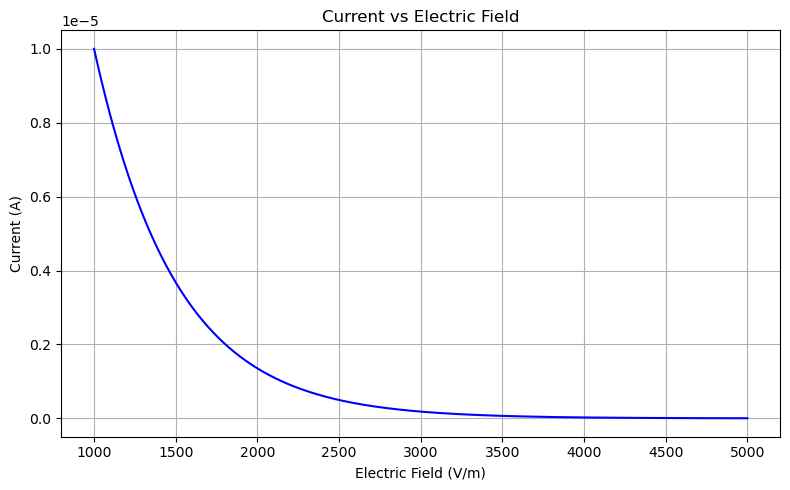

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Electric field from 1000 to 5000 V/m
E = np.linspace(1000, 5000, 500)

# Exponential decay: tune k to make it visibly decay over the given range
I = 1e-5 * np.exp(-0.002 * (E - 1000))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(E, I, color='blue')
plt.xlabel('Electric Field (V/m)')
plt.ylabel('Current (A)')
plt.title('Current vs Electric Field')
plt.grid(True)
plt.tight_layout()
plt.show()


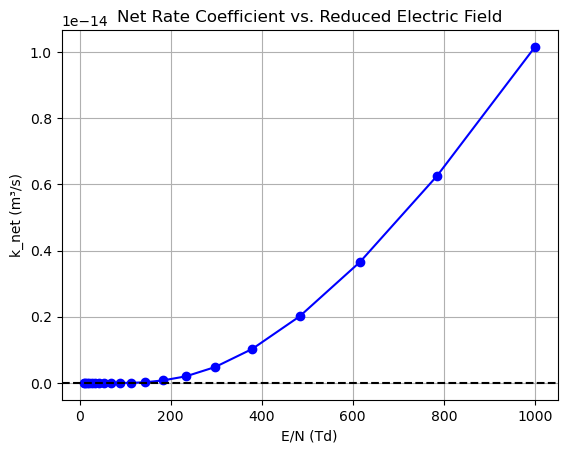

In [43]:
import matplotlib.pyplot as plt

en = [10.00, 12.74, 16.24, 20.69, 26.37, 33.60, 42.81, 54.56, 69.52, 88.59, 112.9, 143.8, 183.3, 233.6, 297.6, 379.3, 483.3, 615.8, 784.8, 1000.0]
knet = [-1.306e-36, -1.236e-36, -8.277e-26, -8.902e-24, -3.516e-22, -6.082e-21, -5.527e-20, -2.951e-19, -1.013e-18, -1.36e-18, 1.624e-18, 1.781e-17, 7.503e-17, 1.979e-16, 4.783e-16, 1.027e-15, 2.012e-15, 3.657e-15, 6.257e-15, 1.016e-14]

plt.plot(en, knet, 'bo-')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('E/N (Td)')
plt.ylabel('k_net (m³/s)')
plt.title('Net Rate Coefficient vs. Reduced Electric Field')
plt.grid(True)
plt.show()